# CSC_51054_EP - Deep Learning
## Lab 7: Deep Learning for Time-series Forecasting

### Section 1. Introduction
#### *What is Time-series Forecasting?*
In machine learning, **time-series forecasting** refers to predicting future values of a variable based on its historical observations. Rather than treating each data point independently, time-series models capture **temporal dependencies**, i.e., how past values influence future outcomes. This requires learning patterns such as trends, seasonal cycles, and irregular fluctuations from sequential data.


#### *Why is Time-series Forecasting interesting?*
- ✅ **Foundation of practical applications**: Stock price prediction, demand forecasting, weather prediction, energy consumption, anomaly detection, all of them rely on accurate time-series models.

- 🧠 **Learning complex temporal patterns**: Deep learning excels where traditional methods (e.g., ARIMA) fail, capturing non-linear dependencies and long-range temporal correlations through LSTMs, Transformers, and attention mechanisms.

- 🔄 **Bridging past and future**: A strong time-series model helps systems understand "what happened before" and "what comes next", which is not only crucial for decision-making in finance, healthcare, and autonomous systems, but also **unveiling cosmic secrets**! In astrophysics research, time-series deep learning helps us listen to the universe and understand its most violent and mysterious moments, such as the prediction of stellar light curves or identifying transient events like supernovae or gamma-ray bursts.

- 🚀 **Real-world impact**: Even 1-2% improvements in forecasting accuracy translate to millions in cost savings for retailers and energy companies, or life-saving interventions in healthcare.

![WASP-126 exoplanet system](./WASP126.png)


### Section 2: Lab Overview and Setup

In this lab, we will explore three machine learning approaches to the **time-series forecasting** tasks, comparing classical and deep learning methods on real astronomical data from NASA's **TESS** (Transiting Exoplanet Survey Satellite) mission.

#### 🧭 Lab Structure

1. **Classical Methods**: KNN classifier with Dynamic Time Warping (DTW). A distance-based approach to time series similarity for classification.
   
2. **Deep Learning Baseline**: Recurrent Neural Networks (LSTM) for light curve predictions.
   
3. **Advanced Architecture**: Transformer for light curve predictions.
  
4. **Discussion**: What is still missing in these data-driven paradigms (if we have time)?

#### 🌟 Dataset: WASP-126 Exoplanet System

We use real time-series observations from **TESS** (Transiting Exoplanet Survey Satellite), a NASA mission that continuously monitors stars for small periodic dips in brightness caused by orbiting exoplanets.

**System Details:**
- **Target**: TIC 25155310 [(**WASP-126**)](http://www.exoplanetkyoto.org/exohtml/WASP-126.html) - 52 TESS observation sectors (2018-2025).
- **Exoplanet**: WASP-126 b.
- **Data**: ~18,278 photometric measurements with ~30-minute cadence.
- **Signal**: Transit events produce ~0.2% flux dips as the planet crosses its star.
- **Location**: Constellation Hydrus, ~700 light-years away.


**WASP-126 b** (the one we're observing):
- A **hot Jupiter**: a gas giant orbiting extremely close to its star
- Mass: 0.28 Jupiter masses
- Orbital period: **3.288 days** 
- Surface temperature: ~1,400 K (much hotter than any planet in our Solar System)


### 🎯 Downstream Task: Transit Prediction

#### **Task 1: Transit Classification (Sections 4)**

**Goal**: Given a short segment of a light curve, classify whether it contains a transit event.

- **Input**: 100-point flux time series
- **Output**: Binary label (0 = no transit, 1 = transit)
- **Evaluation**: Classification accuracy

#### **Task 2: Transit Sequence Prediction (Sections 5-6)**

**Goal**: Given the first 70% of a transit light curve, predict the remaining 30% flux values.

- **Input**: Partial time series (70 flux measurements)
- **Output**: Continuous prediction of next 30 flux values
- **Evaluation**: Mean Squared Error (MSE), visual comparison

### 📊 Astronomical Background

Exoplanet transits are the primary method for discovering and characterizing planets around distant stars. When a planet passes in front of its star from our perspective, it blocks a small fraction of the star's light. These periodic dimming events, repeated over months or years of observation, create a "fingerprint" that reveals the planet's orbital period, size, and atmospheric properties. Your forecasting models will implicitly learn these orbital mechanics from the photometric time series.




In [1]:
### setup the environment
## We need to install the lightkurve package for the TESS dataset
!pip install lightkurve -q

# Standard libraries
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
import math

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# FIX RANDOMNESS: Set all random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)
print(f"Lightkurve version: {lk.__version__}")

  DEPRECATION: Building 'fbpca' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fbpca'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'memoization' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'memoization'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the pa

cpu
Lightkurve version: 2.5.1


### Section 3: Prepare, Analyze, and Visualize the Dataset

In this section, we search for WASP-126 in the TESS archive, download years of exoplanet transit observations, explore the photometric time series, as well as preparing the dataset for experiments. 

While there are no coding tasks here, take a moment to examine the periodic signals and understand how we parse those raw data, as you are looking at real astronomical data from a star 700 light-years away.

Searching for the WASP-126 system from the Universe...
Found 52 results
SearchResult containing 52 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120    25155310      0.0
  1 TESS Sector 02 2018   SPOC     120    25155310      0.0
  2 TESS Sector 03 2018   SPOC     120    25155310      0.0
  3 TESS Sector 04 2018   SPOC     120    25155310      0.0
  4 TESS Sector 05 2018   SPOC     120    25155310      0.0
  5 TESS Sector 06 2018   SPOC     120    25155310      0.0
  6 TESS Sector 13 2019   SPOC     120    25155310      0.0
  7 TESS Sector 12 2019   SPOC     120    25155310      0.0
  8 TESS Sector 11 2019   SPOC     120    25155310      0.0
  9 TESS Sector 09 2019   SPOC     120    25155310      0.0
 10 TESS Sector 08 2019   SPOC     120    25155310      0.0
 11 TESS Sector 07 2019   SPOC     120    251

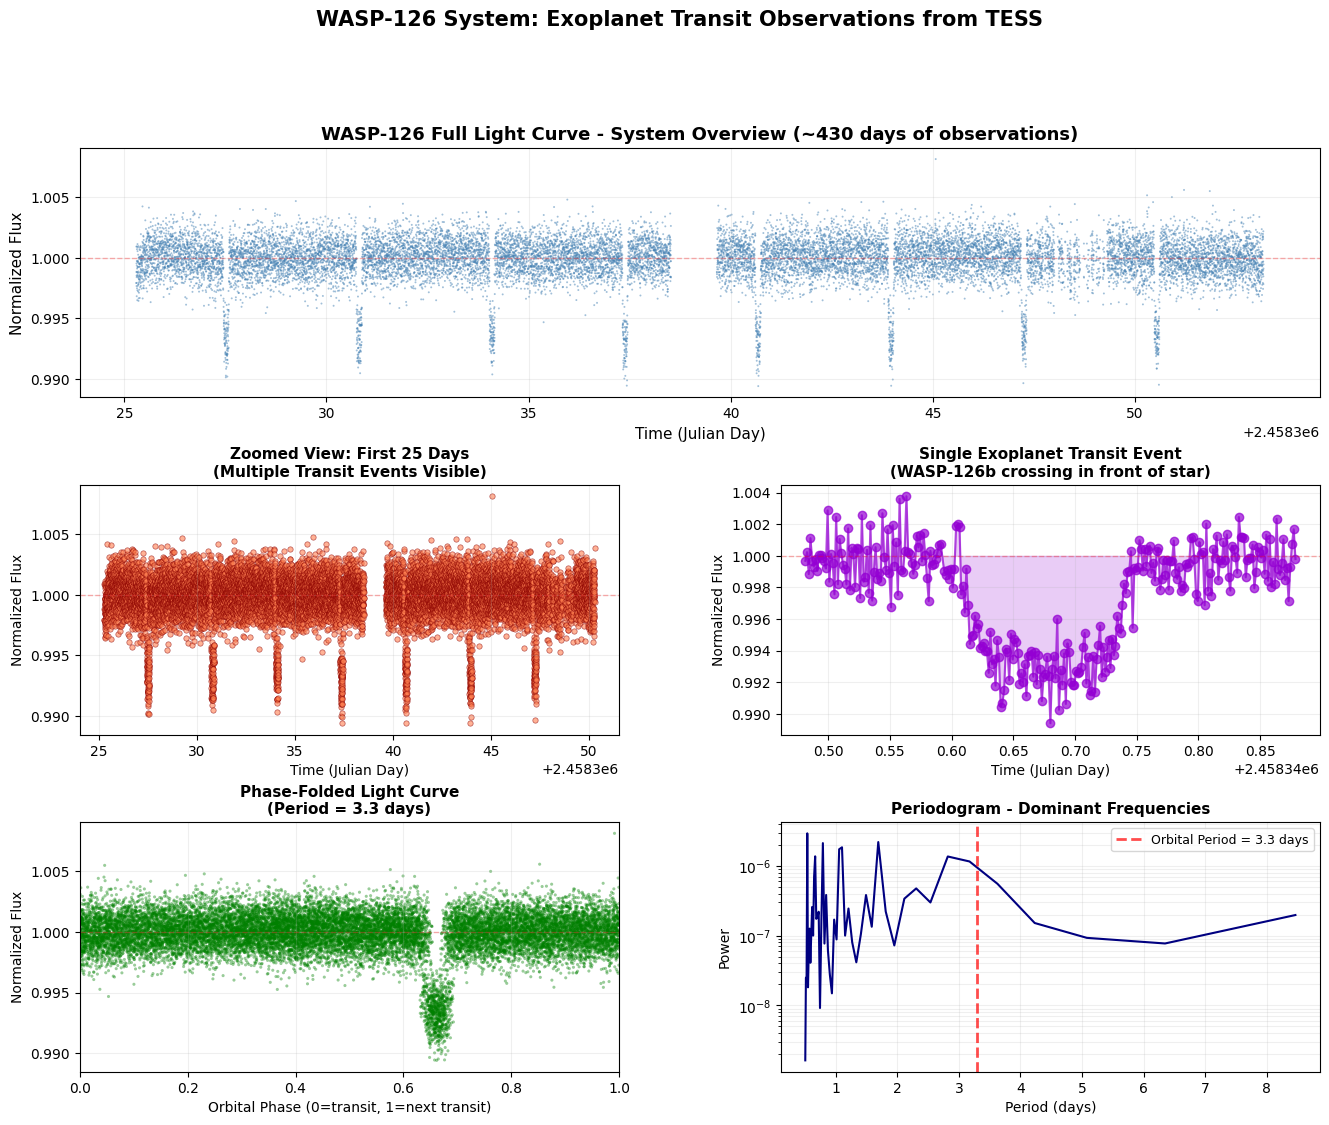


✓ Visualization complete!

📊 Key Statistics:
   - Orbital period: 3.3 days
   - Transit depth: 1.060%
   - Number of observed transits: ~8


In [3]:
# ============================================================
# STEP 0: SEARCH AND DOWNLOAD OUR EXOPLANT SYSTEM
# ============================================================
print("Searching for the WASP-126 system from the Universe...")
sr = lk.search_lightcurve('TIC 25155310', mission='TESS', author='SPOC')
print(f"Found {len(sr)} results")
print(sr)

print("\nDownloading data...")
lc = sr[0].download()
print(f"✓ Successfully downloaded!")

# ============================================================
# STEP 1: PREPARE DATA
# ============================================================
time = lc.time.jd
flux = lc.flux.value

# Remove NaN values
mask = ~np.isnan(flux)
time_clean = time[mask]
flux_clean = flux[mask]

# Normalize flux (center at 1)
flux_norm = flux_clean / np.median(flux_clean)

print(f"✓ Data prepared: {len(flux_clean)} points over {time_clean[-1] - time_clean[0]:.1f} days")

# ============================================================
# STEP 2: CREATE COMPREHENSIVE VISUALIZATION
# ============================================================

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# --- Panel 1: Full Time Series ---
ax1 = fig.add_subplot(gs[0, :])
ax1.scatter(time_clean, flux_norm, s=2, alpha=0.5, color='steelblue', edgecolors='none')
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_xlabel('Time (Julian Day)', fontsize=11)
ax1.set_ylabel('Normalized Flux', fontsize=11)
ax1.set_title('WASP-126 Full Light Curve - System Overview (~430 days of observations)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.2)

# --- Panel 2: Zoomed Sector (First 25 days) ---
ax2 = fig.add_subplot(gs[1, 0])
zoom_idx = time_clean < time_clean[0] + 25
ax2.scatter(time_clean[zoom_idx], flux_norm[zoom_idx], s=15, alpha=0.6, 
           color='coral', edgecolors='darkred', linewidth=0.5)
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax2.set_xlabel('Time (Julian Day)', fontsize=10)
ax2.set_ylabel('Normalized Flux', fontsize=10)
ax2.set_title('Zoomed View: First 25 Days\n(Multiple Transit Events Visible)', 
              fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.2)

# --- Panel 3: Ultra-Zoom (Single Transit) ---
ax3 = fig.add_subplot(gs[1, 1])
# Find the deepest dip (likely a transit)
dip_idx = np.argmin(flux_norm)
dip_window = 0.2  # days around dip
transit_mask = np.abs(time_clean - time_clean[dip_idx]) < dip_window
ax3.plot(time_clean[transit_mask], flux_norm[transit_mask], 'o-', 
        markersize=6, color='darkviolet', linewidth=1.5, alpha=0.7)
ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax3.fill_between(time_clean[transit_mask], flux_norm[transit_mask], 1.0, 
                 alpha=0.2, color='darkviolet')
ax3.set_xlabel('Time (Julian Day)', fontsize=10)
ax3.set_ylabel('Normalized Flux', fontsize=10)
ax3.set_title('Single Exoplanet Transit Event\n(WASP-126b crossing in front of star)', 
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.2)

# --- Panel 4: Phase-Folded Light Curve ---
ax4 = fig.add_subplot(gs[2, 0])
orbital_period = 3.3  # days (WASP-126b's orbital period)
phase = ((time_clean - time_clean[0]) % orbital_period) / orbital_period  # 0 to 1
# Sort by phase
sort_idx = np.argsort(phase)
ax4.scatter(phase[sort_idx], flux_norm[sort_idx], s=5, alpha=0.4, 
           color='green', edgecolors='none')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax4.set_xlabel('Orbital Phase (0=transit, 1=next transit)', fontsize=10)
ax4.set_ylabel('Normalized Flux', fontsize=10)
ax4.set_title(f'Phase-Folded Light Curve\n(Period = {orbital_period} days)', 
              fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.2)
ax4.set_xlim([0, 1])

# --- Panel 5: Periodogram (Power Spectrum) ---
ax5 = fig.add_subplot(gs[2, 1])
# Compute periodogram
frequencies, power = signal.periodogram(flux_norm - 1.0, fs=1.0/(time_clean[1]-time_clean[0]))
periods = 1 / frequencies[1:]  # Convert to periods (skip f=0)
power = power[1:]
# Focus on reasonable period range (0.5 to 10 days)
period_mask = (periods > 0.5) & (periods < 10)
ax5.semilogy(periods[period_mask], power[period_mask], linewidth=1.5, color='navy')
# Mark the known period
ax5.axvline(x=orbital_period, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Orbital Period = {orbital_period} days')
ax5.set_xlabel('Period (days)', fontsize=10)
ax5.set_ylabel('Power', fontsize=10)
ax5.set_title('Periodogram - Dominant Frequencies', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.2, which='both')

plt.suptitle('WASP-126 System: Exoplanet Transit Observations from TESS', 
            fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("\n✓ Visualization complete!")
print(f"\n📊 Key Statistics:")
print(f"   - Orbital period: {orbital_period} days")
print(f"   - Transit depth: {(1 - np.min(flux_norm))*100:.3f}%")
print(f"   - Number of observed transits: ~{(time_clean[-1] - time_clean[0]) / orbital_period:.0f}")


In [5]:
#### Step 1 - Preprocessing: classify the data into two classes for classification, or partition them for prediction
print("STEP 2: Extracting fixed-length segments...\n")

segment_length = 100
n_segments = len(flux_norm) // segment_length

segments = []
for i in range(n_segments):
    start_idx = i * segment_length
    end_idx = start_idx + segment_length
    segment = flux_norm[start_idx:end_idx]
    segments.append(segment)

segments = np.array(segments)
print(f"✓ Extracted {len(segments)} segments ({segment_length} points each)\n")

# Compute noise level: std dev of each segment
segment_stds = segments.std(axis=1)

# Use median as threshold to balance classes
noise_threshold = np.median(segment_stds)

y_classification = (segment_stds >= noise_threshold).astype(int)

X_classification = segments.copy()
y_classification_final = y_classification.copy()

print(f"✓ Classification dataset:")
print(f"  Total samples: {len(X_classification)}")
print(f"  Class distribution: {np.bincount(y_classification_final)}\n")

# Prediction task: use low-noise segments (assumed to contain transits)
low_noise_segments = segments[y_classification == 0]

if len(low_noise_segments) > 0:
    split_point = int(segment_length * 0.7)
    
    X_predict_input = low_noise_segments[:, :split_point]
    X_predict_target = low_noise_segments[:, split_point:]
    
    print(f"✓ Prediction dataset (using {len(low_noise_segments)} low-noise segments):")
    print(f"  Input (first 70%):  {X_predict_input.shape}")
    print(f"  Target (last 30%):  {X_predict_target.shape}\n")
else:
    print(f"  ⚠ No low-noise segments found\n")
    X_predict_input = np.array([])
    X_predict_target = np.array([])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification_final, test_size=0.2, random_state=42, stratify=y_classification_final
)

if len(X_predict_input) > 0:
    X_train_pred_input, X_test_pred_input, X_train_pred_target, X_test_pred_target = train_test_split(
        X_predict_input, X_predict_target, test_size=0.2, random_state=42
    )
else:
    X_train_pred_input = np.array([])
    X_test_pred_input = np.array([])
    X_train_pred_target = np.array([])
    X_test_pred_target = np.array([])

print(f"✓ Classification splits:")
print(f"  Train: {X_train_clf.shape} | Classes: {np.bincount(y_train_clf.astype(int))}")
print(f"  Test:  {X_test_clf.shape} | Classes: {np.bincount(y_test_clf.astype(int))}\n")

if len(X_predict_input) > 0:
    print(f"✓ Prediction splits:")
    print(f"  Train: {X_train_pred_input.shape} → {X_train_pred_target.shape}")
    print(f"  Test:  {X_test_pred_input.shape} → {X_test_pred_target.shape}\n")


STEP 2: Extracting fixed-length segments...

✓ Extracted 182 segments (100 points each)

✓ Classification dataset:
  Total samples: 182
  Class distribution: [91 91]

✓ Prediction dataset (using 91 low-noise segments):
  Input (first 70%):  (91, 70)
  Target (last 30%):  (91, 30)

✓ Classification splits:
  Train: (145, 100) | Classes: [72 73]
  Test:  (37, 100) | Classes: [19 18]

✓ Prediction splits:
  Train: (72, 70) → (72, 30)
  Test:  (19, 70) → (19, 30)



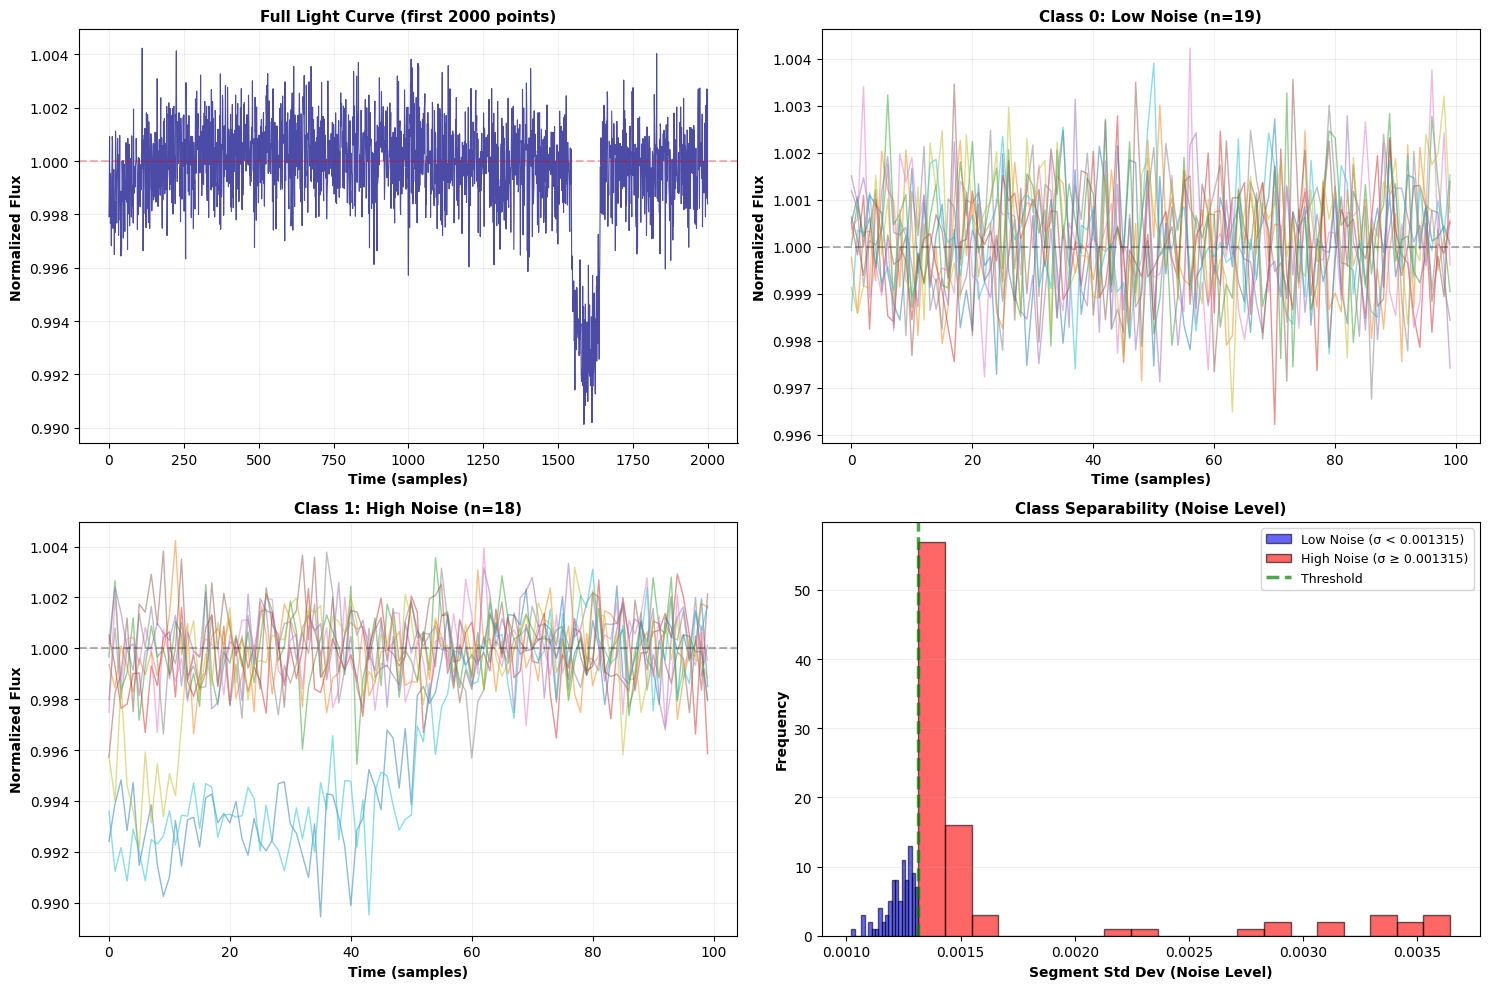

In [6]:
#### Step 2 - Visualize some samples from the dataset split

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Full light curve
ax1 = axes[0, 0]
ax1.plot(flux_norm[:2000], linewidth=0.8, color='navy', alpha=0.7)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.3)
ax1.set_xlabel('Time (samples)', fontsize=10, fontweight='bold')
ax1.set_ylabel('Normalized Flux', fontsize=10, fontweight='bold')
ax1.set_title('Full Light Curve (first 2000 points)', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.2)

# Plot 2: Class 0 (Low noise) examples
ax2 = axes[0, 1]
class_0_samples = X_test_clf[y_test_clf == 0]
for i in range(min(10, len(class_0_samples))):
    ax2.plot(class_0_samples[i], alpha=0.5, linewidth=1)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (samples)', fontsize=10, fontweight='bold')
ax2.set_ylabel('Normalized Flux', fontsize=10, fontweight='bold')
ax2.set_title(f'Class 0: Low Noise (n={np.sum(y_test_clf == 0)})', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.2)

# Plot 3: Class 1 (High noise) examples
ax3 = axes[1, 0]
class_1_samples = X_test_clf[y_test_clf == 1]
for i in range(min(10, len(class_1_samples))):
    ax3.plot(class_1_samples[i], alpha=0.5, linewidth=1)
ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.3)
ax3.set_xlabel('Time (samples)', fontsize=10, fontweight='bold')
ax3.set_ylabel('Normalized Flux', fontsize=10, fontweight='bold')
ax3.set_title(f'Class 1: High Noise (n={np.sum(y_test_clf == 1)})', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.2)

# Plot 4: Noise level distribution
ax4 = axes[1, 1]
ax4.hist(segment_stds[y_classification_final == 0], bins=20, alpha=0.6, 
         label=f'Low Noise (σ < {noise_threshold:.6f})', color='blue', edgecolor='black')
ax4.hist(segment_stds[y_classification_final == 1], bins=20, alpha=0.6, 
         label=f'High Noise (σ ≥ {noise_threshold:.6f})', color='red', edgecolor='black')
ax4.axvline(x=noise_threshold, color='green', linestyle='--', linewidth=2.5, alpha=0.7, label='Threshold')
ax4.set_xlabel('Segment Std Dev (Noise Level)', fontsize=10, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax4.set_title('Class Separability (Noise Level)', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.2, axis='y')
ax4.legend(fontsize=9)

plt.tight_layout()
plt.show()

### Section 4: Classical Methods for Event Classifications - Distance-Based Time Series Comparison

#### *What is Distance-Based Time Series Analysis?*

**Distance-based approaches** are classical machine learning methods that compare time series by measuring similarity using distance metrics. Rather than learning patterns from data, these methods rely on pre-defined distance functions to compare sequences directly. For time series that may be shifted or scaled versions of each other, specialized metrics like **Dynamic Time Warping (DTW)** are used instead of simple Euclidean distance.

The core idea is elegantly simple but effective:

- **Intuitive distance metrics**: Euclidean distance works for aligned sequences, but DTW allows flexible alignment by "warping" the time axis to find optimal matching.

- **No training required**: These methods are parameter-free and don't require optimization. 

- **Interpretability**: The similar time series are explicit, so that we can directly see which training example the test series matched with.

- **Baseline strength**: Despite their simplicity, distance-based methods could also outperform sophisticated deep learning on small, well-behaved datasets.

<span style="color:blue">**Tasks:**</span> Fill in the indicated blanks in the following code cells to implement distance-based time series 
classification on exoplanet transit.

- Implement KNN classifier with Euclidean distance;
- Implement KNN classifier with DTW distance metrics (details of DTW in the lecture slides);
- Evaluate and compare classification performance between the two distance metrics.

In [11]:
#### KNN WITH EUCLIDEAN DISTANCE
print("="*70)
print("METHOD 1: KNN with Euclidean Distance")
print("="*70 + "\n")

knn_euclidean = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_euclidean.fit(X_train_clf, y_train_clf)

#### TO BE FILLED: test and compute the scores with knn_euclidean
y_pred_euclidean = knn_euclidean.predict(X_test_clf)

score_euclidean = np.sum(y_pred_euclidean== y_test_clf)/len(y_test_clf)

print(f"Test Accuracy: {score_euclidean:.4f}\n")
print()

#### KNN WITH DYNAMIC TIME WARPING (DTW)

print("="*70)
print("METHOD 2: KNN with Dynamic Time Warping (DTW)")
print("="*70 + "\n")

def dtw_distance(x, y):
    """
    Compute Dynamic Time Warping distance between two sequences.
    
    DTW allows flexible alignment by "warping" the time axis to find
    the optimal matching between sequences.
    """
    n, m = len(x), len(y)
    
    # Initialize DTW cost matrix
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Cost is absolute difference between points
            cost = abs(x[i-1] - y[j-1])
            
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j  ],    # insertion
                                        dtw_matrix[i  , j-1],    # deletion
                                        dtw_matrix[i-1, j-1])    # match
    
    return dtw_matrix[n, m]


# Precompute DTW distance matrix between all test and train samples
n_test = len(X_test_clf)
n_train = len(X_train_clf)
dtw_distances = np.zeros((n_test, n_train))

for i in range(n_test):
    for j in range(n_train):
        dtw_distances[i, j] = dtw_distance(X_test_clf[i], X_train_clf[j])
    
    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{n_test} test samples")


# Classify using nearest neighbor in DTW space
y_pred_dtw = np.zeros(n_test, dtype=int)
for i in range(n_test):
    idx = dtw_distances[i,:].argsort()
    sorted_labels = y_train_clf[idx]
    classes, counts = np.unique(sorted_labels[:3], return_counts=True)
    y_pred_dtw[i] = classes[np.argmax(counts)]  

score_dtw = np.mean(y_pred_dtw == y_test_clf)

print(f"Test Accuracy: {score_dtw:.4f}\n")

METHOD 1: KNN with Euclidean Distance

Test Accuracy: 0.5676


METHOD 2: KNN with Dynamic Time Warping (DTW)

  Processed 10/37 test samples
  Processed 20/37 test samples
  Processed 30/37 test samples
Test Accuracy: 0.6216



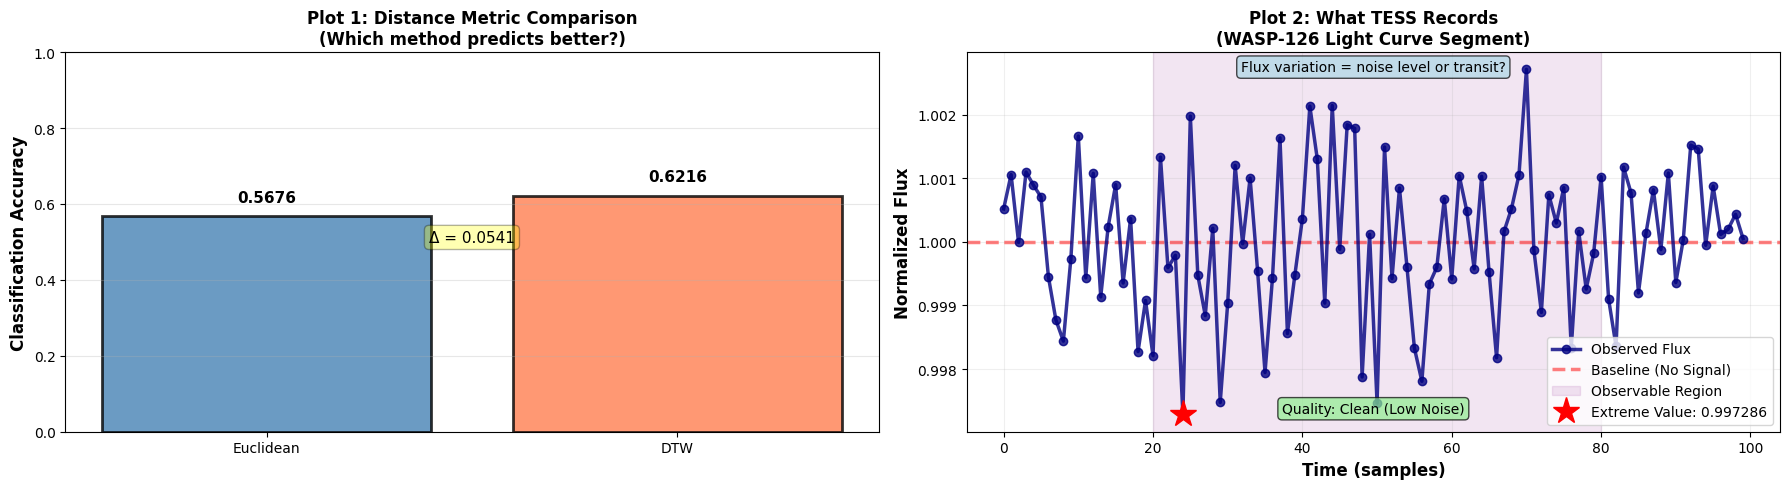

In [13]:
# THREE-FIGURE VISUALIZATION (with physics explanation)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# ---------------------------------------------------------------
# Plot 1: Accuracy Comparison
# ---------------------------------------------------------------
methods = ['Euclidean', 'DTW']
scores = [score_euclidean, score_dtw]
colors = ['steelblue', 'coral']

bars = axes[0].bar(methods, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Classification Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Plot 1: Distance Metric Comparison\n(Which method predicts better?)', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.03,
                f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add annotation
axes[0].text(0.5, 0.5, f'Δ = {abs(score_dtw - score_euclidean):.4f}', 
            transform=axes[0].transAxes, ha='center', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# ---------------------------------------------------------------
# Plot 2: Example Light Curve (Physics Explanation)
# ---------------------------------------------------------------
example_idx = 0
light_curve = X_test_clf[example_idx]

axes[1].plot(light_curve, 'o-', markersize=6, linewidth=2.5, color='navy', 
            alpha=0.8, label='Observed Flux', zorder=3)
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2.5, 
               label='Baseline (No Signal)', zorder=2)

# Highlight the noise variation region
axes[1].axvspan(20, 80, alpha=0.1, color='purple', 
               label='Observable Region', zorder=1)

# Mark the deepest/brightest point
extreme_idx = np.argmin(light_curve)
axes[1].plot(extreme_idx, light_curve[extreme_idx], 'r*', markersize=20, 
            label=f'Extreme Value: {light_curve[extreme_idx]:.6f}', zorder=4)

axes[1].set_xlabel('Time (samples)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Normalized Flux', fontsize=12, fontweight='bold')
axes[1].set_title('Plot 2: What TESS Records\n(WASP-126 Light Curve Segment)', 
                 fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.2)
axes[1].legend(fontsize=10, loc='lower right')

# Physical interpretation
axes[1].text(0.5, 0.95, 'Flux variation = noise level or transit?', 
            transform=axes[1].transAxes, ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Quality label
true_label = int(y_test_clf[example_idx])
quality_names = ['Clean (Low Noise)', 'Noisy (High Noise)']
quality_colors = ['lightgreen', 'lightyellow']

axes[1].text(0.5, 0.05, f'Quality: {quality_names[true_label]}', 
            transform=axes[1].transAxes, ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor=quality_colors[true_label], alpha=0.7))

plt.tight_layout()
plt.show()



<span style="color:orange">**Questions:**</span> 
 - Q1: Why does DTW outperform Euclidean distance?
 - Q2: What do the spikes in the transit plot represent?
 - Q3: Why is DTW much slower than Euclidean distance?

### Section 5: Deep Learning - LSTM for Time Series Prediction

#### What is an LSTM for Time Series Prediction (a recap from previous labs)?

**Long Short-Term Memory (LSTM)** networks are recurrent neural networks designed to learn temporal dependencies in sequential data. Unlike distance-based methods that compare entire sequences at once, LSTMs process sequences step-by-step, maintaining an internal "memory" (hidden state and cell state) that captures relevant information from past observations.

In **time series prediction**, we train the LSTM to learn the underlying dynamics of the signal, enabling it to forecast future values given partial observations. For WASP-126's light curve, we use the **first 70% of a signal** to predict the **remaining 30%**, testing whether the model learns the shape and structure of exoplanet transits.


<span style="color:blue">**Tasks:**</span> Fill in the indicated blanks to build and train an LSTM for sequence prediction:

- Define an LSTM-based neural network for regression;
- Train the model on the training set;
- Evaluate prediction accuracy, MSE, RMSE, and MAE on the test set;
- Analyze and visualize predictions vs. ground truth.


In [27]:
## The data splits have already been defined in Section 3.

# Convert to PyTorch tensors with proper shape for LSTM
# Shape: (batch_size, sequence_length, num_features)
X_train_input_tensor = torch.FloatTensor(X_train_pred_input).unsqueeze(-1)  # (N_train, 70, 1)
X_train_target_tensor = torch.FloatTensor(X_train_pred_target)  # (N_train, 30)
X_test_input_tensor = torch.FloatTensor(X_test_pred_input).unsqueeze(-1)    # (N_test, 70, 1)
X_test_target_tensor = torch.FloatTensor(X_test_pred_target)                # (N_test, 30)

batch_size = 4
train_dataset = TensorDataset(X_train_input_tensor, X_train_target_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



## DEFINE LSTM MODEL

class LSTMPredictor(nn.Module):
    """LSTM model for time series prediction."""
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=30, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer: processes sequence and maintains hidden state
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        #### TO BE FILLED
        # Fully connected layers: map LSTM output to prediction
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout)
        self.fc2 =  nn.Linear(hidden_size, output_size) # Predict 30 timesteps


    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_size)
        
        Returns:
            predictions: (batch_size, output_size)
        """
        # LSTM forward: processes entire sequence
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch_size, seq_len, hidden_size)
        
        # Fully connected prediction
        h_n = h_n.view(-1, self.hidden_size)
    
        hidden = self.fc1(h_n)
        hidden = self.relu(hidden)
        hidden = self.dropout_layer(hidden)
        predictions = self.fc2(hidden)  # (batch_size, 30)
        
        return predictions




In [35]:
# Initialize model
model = LSTMPredictor(
    input_size=1,
    hidden_size=64,
    num_layers=1,
    output_size=30,
    dropout=0.2
)
model = model.to(device)

### TO BE FILLED: 
# Mean Squared Error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # ==================== TRAIN ====================
    model.train()
    batch_loss = 0
    
    for batch_input, batch_target in train_loader:
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        ### TO BE FILLED
        # Forward pass
        model.zero_grad()
        predictions = model(batch_input).to(device)
        loss = criterion(predictions, batch_target)

        ### TO BE FILLED
        # Backward pass
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        batch_loss += loss.item()

    avg_train_loss = batch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ==================== VALIDATION ====================
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_input_tensor.to(device))
        test_loss = criterion(test_predictions, X_test_target_tensor.to(device))
        test_losses.append(test_loss.item())
    
    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {test_losses[-1]:.6f}")

print(f"\n✓ Training complete!\n")


Epoch [ 20/100] Train Loss: 0.046650, Test Loss: 0.002631
Epoch [ 40/100] Train Loss: 0.036124, Test Loss: 0.001385
Epoch [ 60/100] Train Loss: 0.025911, Test Loss: 0.003023
Epoch [ 80/100] Train Loss: 0.023420, Test Loss: 0.000534
Epoch [100/100] Train Loss: 0.016936, Test Loss: 0.001419

✓ Training complete!



In [36]:
model.eval()
with torch.no_grad():

    #### TO BE FILLED, we will compute mse, rmse, and mae as evaluation metrics
    test_predictions = model(X_test_input_tensor)
    test_mse = nn.functional.mse_loss(test_predictions,X_test_target_tensor)
    test_rmse = torch.sqrt(test_mse)
    test_mae = torch.mean(torch.abs(test_predictions - X_test_target_tensor))

print(f"Test Set Performance:")
print(f"  MSE:  {test_mse.item():.8f}")
print(f"  RMSE: {test_rmse.item():.8f}")
print(f"  MAE:  {test_mae.item():.8f}\n")


Test Set Performance:
  MSE:  0.00141947
  RMSE: 0.03767582
  MAE:  0.03717826



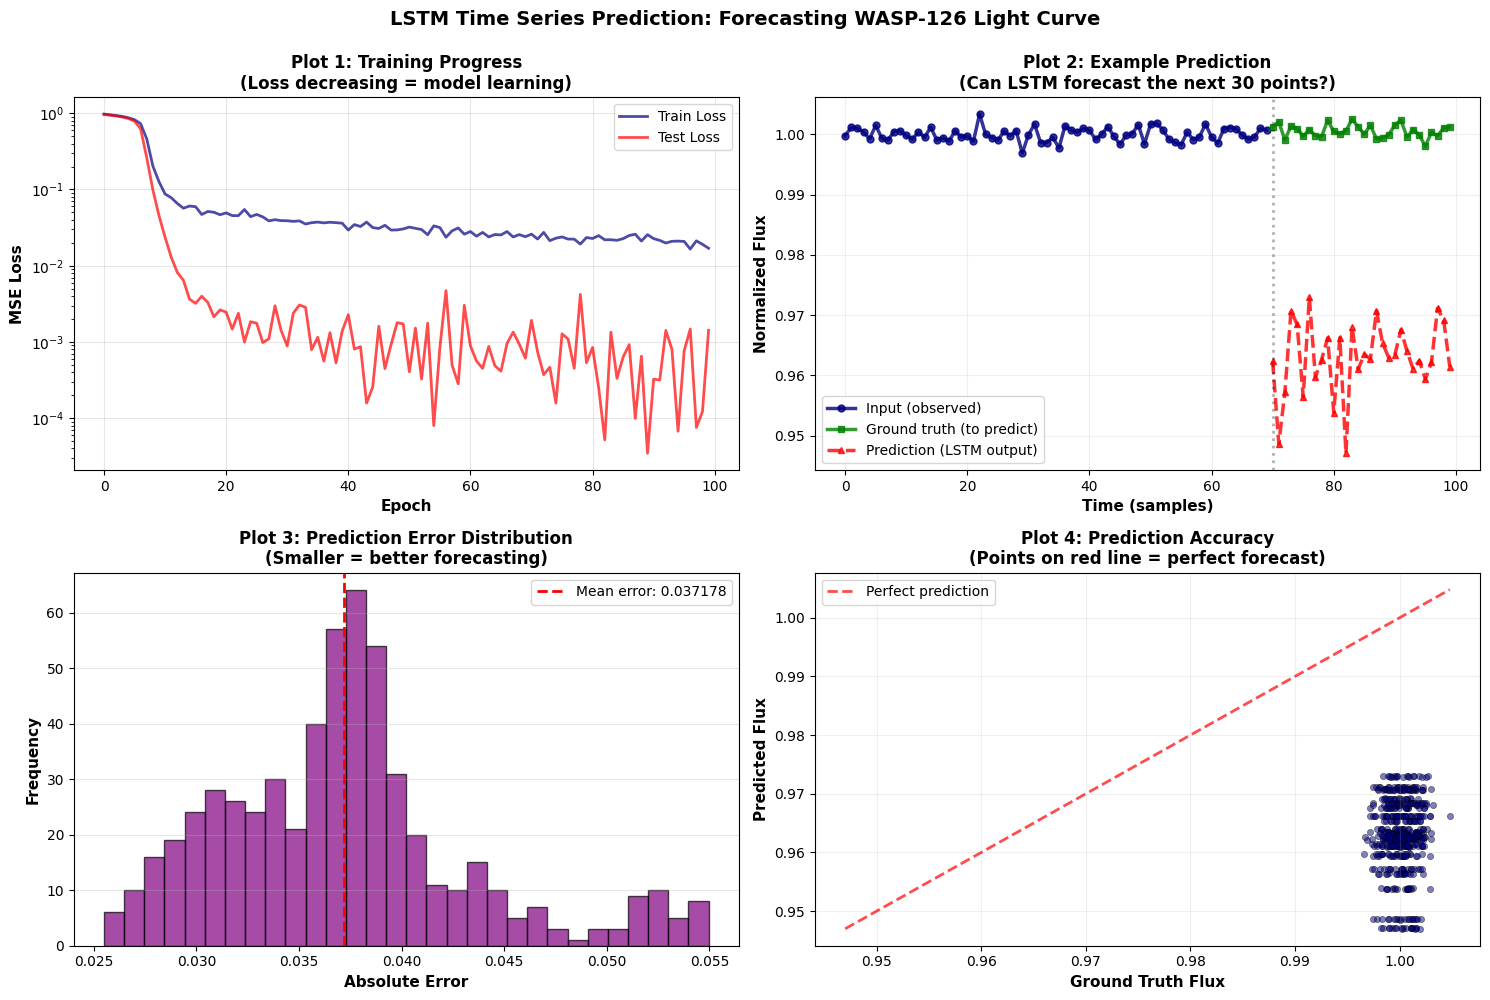

In [37]:
# Convert to numpy for visualization
test_pred_np = test_predictions.cpu().numpy()
test_target_np = X_test_target_tensor.numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss curves
ax1 = axes[0, 0]
ax1.plot(train_losses, linewidth=2, label='Train Loss', color='navy', alpha=0.7)
ax1.plot(test_losses, linewidth=2, label='Test Loss', color='red', alpha=0.7)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
ax1.set_title('Plot 1: Training Progress\n(Loss decreasing = model learning)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_yscale('log')

# Plot 2: Example prediction vs ground truth
ax2 = axes[0, 1]
example_idx = 0

time_input = np.arange(70)
time_output = np.arange(70, 100)

ax2.plot(time_input, X_test_pred_input[example_idx], 'o-', linewidth=2.5, 
         markersize=5, color='navy', alpha=0.8, label='Input (observed)')
ax2.plot(time_output, test_target_np[example_idx], 's-', linewidth=2.5, 
         markersize=5, color='green', alpha=0.8, label='Ground truth (to predict)')
ax2.plot(time_output, test_pred_np[example_idx], '^--', linewidth=2.5, 
         markersize=5, color='red', alpha=0.8, label='Prediction (LSTM output)')

ax2.axvline(x=70, color='black', linestyle=':', alpha=0.3, linewidth=2)
ax2.set_xlabel('Time (samples)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Normalized Flux', fontsize=11, fontweight='bold')
ax2.set_title('Plot 2: Example Prediction\n(Can LSTM forecast the next 30 points?)', 
             fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.2)
ax2.legend(fontsize=10)

# Plot 3: Residuals (prediction errors)
ax3 = axes[1, 0]
residuals = test_target_np - test_pred_np
errors = np.abs(residuals)

ax3.hist(errors.flatten(), bins=30, color='purple', alpha=0.7, edgecolor='black')
ax3.axvline(x=errors.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean error: {errors.mean():.6f}')
ax3.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Plot 3: Prediction Error Distribution\n(Smaller = better forecasting)', 
             fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(fontsize=10)

# Plot 4: Predicted vs Ground Truth (scatter)
ax4 = axes[1, 1]
ax4.scatter(test_target_np.flatten(), test_pred_np.flatten(), 
           alpha=0.5, s=20, color='navy', edgecolor='black', linewidth=0.5)

# Perfect prediction line
min_val = min(test_target_np.min(), test_pred_np.min())
max_val = max(test_target_np.max(), test_pred_np.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7, label='Perfect prediction')

ax4.set_xlabel('Ground Truth Flux', fontsize=11, fontweight='bold')
ax4.set_ylabel('Predicted Flux', fontsize=11, fontweight='bold')
ax4.set_title('Plot 4: Prediction Accuracy\n(Points on red line = perfect forecast)', 
             fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.2)
ax4.legend(fontsize=10)

plt.suptitle('LSTM Time Series Prediction: Forecasting WASP-126 Light Curve', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Section 6: Transformer for Time Series Prediction

#### What is a Transformer (a recap again)?

**Transformers** use **self-attention mechanisms** to process sequences, where each timestep can directly "attend to" all other timesteps simultaneously. Unlike LSTMs that process sequences sequentially (one step at a time), Transformers compute relationships between all positions in parallel, making them both faster and better at capturing long-range temporal dependencies.


<span style="color:blue">**Tasks:**</span> Fill in the indicated blanks to build and train a Transformer for sequence prediction:

- Build a Transformer encoder for sequence prediction;
- Compare performance (MSE, RMSE, MAE) with LSTM from Section 5;
- Visualize attention patterns to understand what the model learned.


In [42]:
### The prediction dataset has been already defined in our previous sections
batch_size = 4
train_loader_tf = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class PositionalEncoding(nn.Module):
    """Add positional information to sequence tokens."""
    
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Sine/cosine basis functions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerPredictor(nn.Module):
    """Transformer for time series prediction."""
    
    def __init__(self, input_size=1, d_model=64, num_heads=4, 
                 num_layers=2, d_ff=256, output_size=30, dropout=0.1):
        super(TransformerPredictor, self).__init__()
        
        self.d_model = d_model
        
        # Project input to embedding dimension
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len=100)
        
        # Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Prediction head
        self.fc1 = nn.Linear(d_model, 128)
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, output_size)
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_size)
        
        Returns:
            predictions: (batch_size, output_size)
        """
        ## TO BE FILLED: Project to embedding dimension
        x =  self.input_proj(x) # (batch, seq_len, d_model)
        
        ## TO BE FILLED: Add positional encoding
        x =  self.pos_encoding(x)+x # (batch, seq_len, d_model)
        
        ## TO BE FILLED: Transformer encoder (self-attention over all timesteps)
        x =  self.transformer_encoder(x) # (batch, seq_len, d_model)
        
        # TO BE FILLED: Global average pooling: aggregate over sequence
        x =  torch.mean(x,dim=1)
        
        # Prediction head
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout_layer(x)
        predictions = self.fc2(x)  # (batch, output_size)
        
        return predictions


In [43]:
# Initialize model
model_tf = TransformerPredictor(
    input_size=1,
    d_model=64,
    num_heads=4,
    num_layers=2,
    d_ff=256,
    output_size=30,
    dropout=0.1
)
model_tf = model_tf.to(device)

criterion_tf = nn.MSELoss()
optimizer_tf = optim.Adam(model_tf.parameters(), lr=0.001)

num_epochs = 100
train_losses_tf = []
test_losses_tf = []

for epoch in range(num_epochs):
    # Train
    model_tf.train()
    batch_loss = 0
    
    for batch_input, batch_target in train_loader_tf:
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)
        
        predictions = model_tf(batch_input)
        loss = criterion_tf(predictions, batch_target)
        
        optimizer_tf.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_norm=1.0)
        optimizer_tf.step()
        
        batch_loss += loss.item()
    
    avg_train_loss = batch_loss / len(train_loader_tf)
    train_losses_tf.append(avg_train_loss)
    
    # Test
    model_tf.eval()
    with torch.no_grad():

        ### TO BE FILLED
        test_predictions_tf = model_tf(X_test_input_tensor)
        test_loss = criterion(test_predictions, X_test_target_tensor)
        
        test_losses_tf.append(test_loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {test_losses_tf[-1]:.6f}")


Epoch [ 20/100] Train Loss: 0.006741, Test Loss: 0.001419
Epoch [ 40/100] Train Loss: 0.004278, Test Loss: 0.001419
Epoch [ 60/100] Train Loss: 0.003960, Test Loss: 0.001419
Epoch [ 80/100] Train Loss: 0.003694, Test Loss: 0.001419
Epoch [100/100] Train Loss: 0.003135, Test Loss: 0.001419


In [45]:
model_tf.eval()
with torch.no_grad():
    
    #test_predictions = model(X_test_input_tensor)
    # test_mse = nn.functional.mse_loss(test_predictions,X_test_target_tensor)
    # test_rmse = torch.sqrt(test_mse)
    # test_mae = torch.mean(torch.abs(test_predictions - X_test_target_tensor))
    #### TO BE FILLED
    test_pred_tf = model_tf(X_test_input_tensor)
    test_mse_tf = nn.functional.mse_loss(test_pred_tf,X_test_target_tensor)
    test_rmse_tf = torch.sqrt(test_mse_tf)
    test_mae_tf = torch.mean(torch.abs(test_pred_tf - X_test_target_tensor))

print(f"Transformer Test Performance:")
print(f"  MSE:  {test_mse_tf.item():.8f}")
print(f"  RMSE: {test_rmse_tf.item():.8f}")
print(f"  MAE:  {test_mae_tf.item():.8f}\n")

# Compare with LSTM
print(f"Comparison: LSTM vs Transformer")
print(f"  LSTM MSE:        {test_mse.item():.8f}")
print(f"  Transformer MSE: {test_mse_tf.item():.8f}")

if test_mse_tf < test_mse:
    improvement = (test_mse.item() - test_mse_tf.item()) / test_mse.item() * 100
    print(f"  ✓ Transformer better by {improvement:.2f}%\n")
else:
    improvement = (test_mse_tf.item() - test_mse.item()) / test_mse_tf.item() * 100
    print(f"  LSTM better by {improvement:.2f}%\n")

Transformer Test Performance:
  MSE:  0.00024564
  RMSE: 0.01567281
  MAE:  0.01509862

Comparison: LSTM vs Transformer
  LSTM MSE:        0.00141947
  Transformer MSE: 0.00024564
  ✓ Transformer better by 82.70%



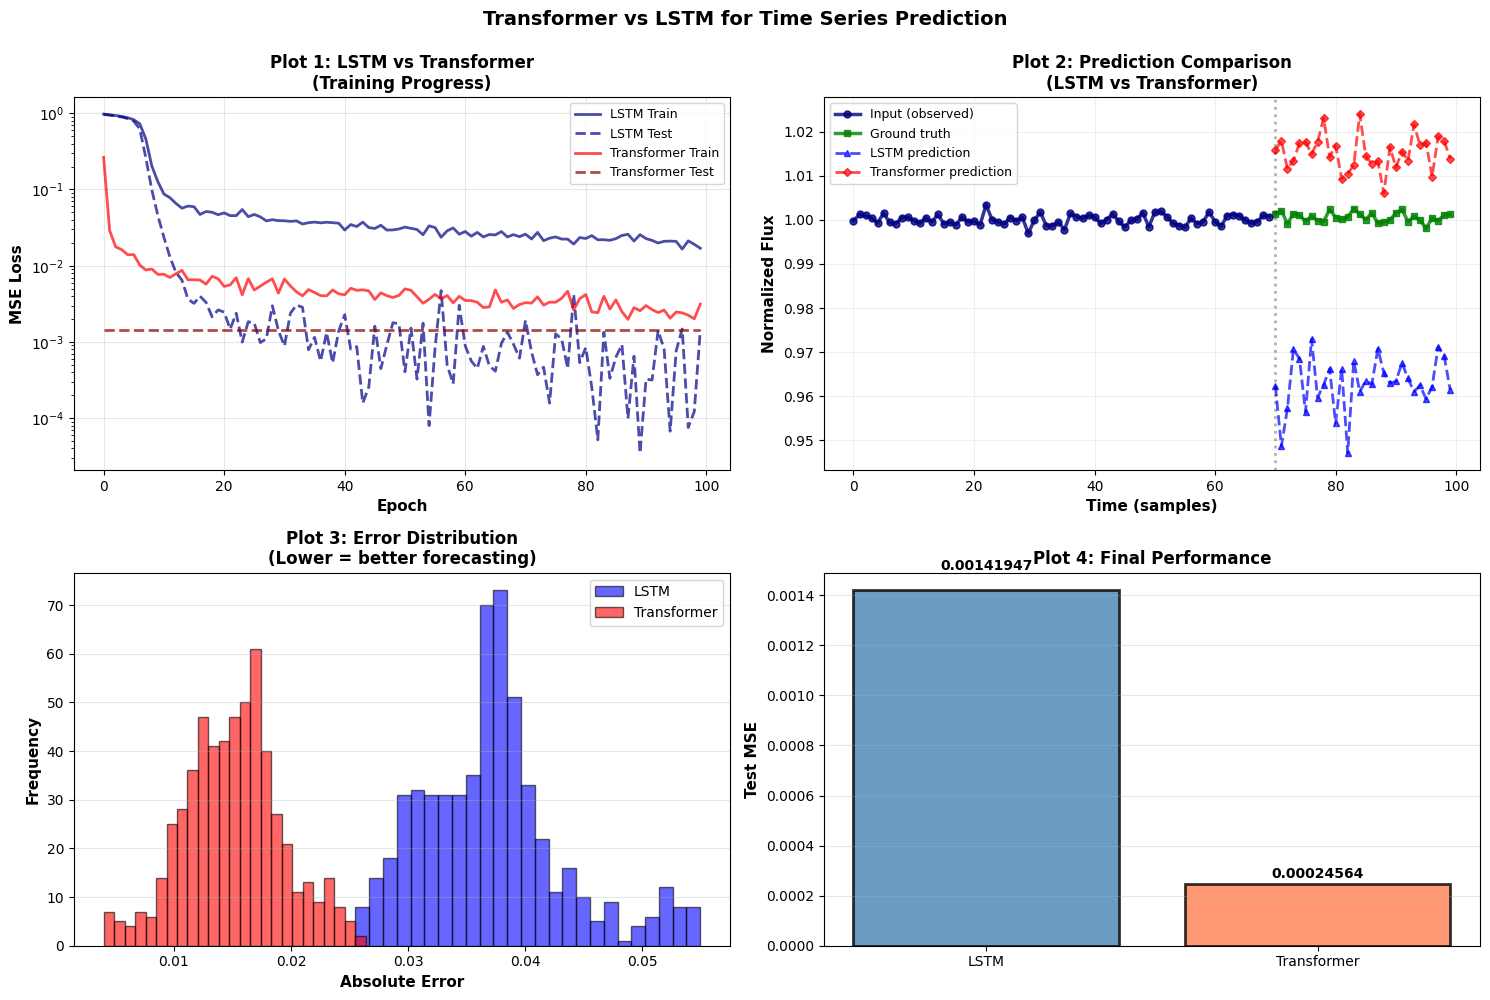

In [46]:
test_pred_tf_np = test_pred_tf.cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training curves comparison
ax1 = axes[0, 0]
ax1.plot(train_losses, linewidth=2, label='LSTM Train', color='navy', alpha=0.7, linestyle='-')
ax1.plot(test_losses, linewidth=2, label='LSTM Test', color='darkblue', alpha=0.7, linestyle='--')
ax1.plot(train_losses_tf, linewidth=2, label='Transformer Train', color='red', alpha=0.7, linestyle='-')
ax1.plot(test_losses_tf, linewidth=2, label='Transformer Test', color='darkred', alpha=0.7, linestyle='--')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
ax1.set_title('Plot 1: LSTM vs Transformer\n(Training Progress)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)
ax1.set_yscale('log')

# Plot 2: Example prediction comparison
ax2 = axes[0, 1]
example_idx = 0

time_input = np.arange(70)
time_output = np.arange(70, 100)

ax2.plot(time_input, X_test_pred_input[example_idx], 'o-', linewidth=2.5, 
         markersize=5, color='navy', alpha=0.8, label='Input (observed)', zorder=3)
ax2.plot(time_output, test_target_np[example_idx], 's-', linewidth=2.5, 
         markersize=5, color='green', alpha=0.8, label='Ground truth', zorder=2)
ax2.plot(time_output, test_pred_np[example_idx], '^--', linewidth=2, 
         markersize=4, color='blue', alpha=0.7, label='LSTM prediction', zorder=1)
ax2.plot(time_output, test_pred_tf_np[example_idx], 'D--', linewidth=2, 
         markersize=4, color='red', alpha=0.7, label='Transformer prediction', zorder=1)

ax2.axvline(x=70, color='black', linestyle=':', alpha=0.3, linewidth=2)
ax2.set_xlabel('Time (samples)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Normalized Flux', fontsize=11, fontweight='bold')
ax2.set_title('Plot 2: Prediction Comparison\n(LSTM vs Transformer)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.2)
ax2.legend(fontsize=9)

# Plot 3: Error distribution
ax3 = axes[1, 0]
errors_lstm = np.abs(test_target_np - test_pred_np)
errors_tf = np.abs(test_target_np - test_pred_tf_np)

ax3.hist(errors_lstm.flatten(), bins=25, alpha=0.6, label='LSTM', color='blue', edgecolor='black')
ax3.hist(errors_tf.flatten(), bins=25, alpha=0.6, label='Transformer', color='red', edgecolor='black')
ax3.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Plot 3: Error Distribution\n(Lower = better forecasting)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(fontsize=10)

# Plot 4: Performance comparison
ax4 = axes[1, 1]
methods = ['LSTM', 'Transformer']
mse_scores = [test_mse.item(), test_mse_tf.item()]
colors_comp = ['steelblue', 'coral']

bars = ax4.bar(methods, mse_scores, color=colors_comp, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('Test MSE', fontsize=11, fontweight='bold')
ax4.set_title('Plot 4: Final Performance', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, mse_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
            f'{score:.8f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Transformer vs LSTM for Time Series Prediction', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### Section 7: Discussion & Future Directions

#### Question: Is Transformer "Good Enough"? The Data-Driven vs Law-Driven Paradox

In this lab, we successfully trained machine learning models to **predict exoplanet transit light curves**. Our Transformer achieved high accuracy on periodic WASP-126 data. But should we celebrate? Let's think deeper.

#### The Success of ML: When Data Reflects Patterns

Machine learning excels at **periodic and recurring patterns**:
- WASP-126's transits repeat every 3.288 days → periodic signal → ML works well
- Photometric observations contain information about orbital mechanics;
- Transformers learn this periodicity from data alone.

**Why?** Because periodic phenomena compress information—the patterns repeat, making data "efficient" for learning.

#### The Fundamental Limitation: Data-Driven vs Law-Driven

Consider the **three-body problem**, which is a chaotic and divergent system, then pure data-driven ML is not good enough.
